In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os
import fiona
import mapclassify as mc
from shapely.geometry import Point, Polygon
from scipy.spatial import KDTree
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [ ]:
def idw_interpolation(gdf, grid_gdf, radius=0, exponent=2, vname=''):
    # New GeoDataFrame with the geometry of the grid
    interpolated_gdf = gpd.GeoDataFrame({'geometry': grid_gdf['geometry']})
    if radius==0:
        # Iterating over the grid
        for idx, point in interpolated_gdf.iterrows():
            distances = gdf.distance(point.geometry)
            weights = 1 / (distances + 0.000001) ** exponent
            interpolated_value = np.sum(weights * gdf[vname]) / np.sum(weights)
            interpolated_gdf.loc[idx, 'pred'] = interpolated_value
    else:
        # Iterating over the grid
        for idx, point in interpolated_gdf.iterrows():
            distances = gdf.distance(point.geometry)
            if len(distances[distances <= radius])!=0:
                # Restringe distances to a maximun radius
                distances = distances[distances <= radius]
            else:
                distances = distances[distances <= radius*2]
            if len(distances)==0:print("No hay puntos")
            weights = 1 / (distances + 0.000001) ** exponent
            interpolated_value = np.sum(weights * gdf[vname].loc[distances.index]) / np.sum(weights)
            interpolated_gdf.loc[idx, 'pred'] = interpolated_value
    return interpolated_gdf

def average_nearest_neighbor_distance(gdf):
    # Extracting the Pionts geometrys from the GeoDataFrame
    points = gdf.geometry.apply(lambda point: (point.x, point.y)).tolist()
    # Create the Kd tree
    tree = KDTree(points)
    # Distance to the nearest neighbor for each point
    distances, _ = tree.query(points, k=2)  # k=2 to exclude the point himself
    nearest_distances = distances[:, 1]
    # Computing the avergage distance
    average_nearest_distance = nearest_distances.mean()
    return average_nearest_distance

def plot_predictions(predictions,vname = 'pred',
colors = [],breaks = [],
plot_size=[10,10], show_plot=True,plot_title = 'Predictions over the grid',
legend_title='Legend',legend=True):
    if len(colors)==0 and len(breaks)==0:
        colors = ['#8FE60C','#ADFF2F','#FFFF00','#FFD700','#FF4500','#FF2500','#FF0000']
        min, max = int(predictions[vname].min())-1,int(predictions[vname].max())+1
        breaks = np.linspace(min, max, 8, endpoint=True)
        breaks = np.round(breaks).astype(int)
        print(len(breaks))
    elif len(colors)+1!=len(breaks):
        return "You must specify a color for each interval"
    elif len(plot_size)!=2 or not isinstance(plot_size,list):
        return "The size of the graph must be specified in a list of two elements"
    elif not isinstance(predictions,gpd.GeoDataFrame):
        return "The grid with the predictions is expected to be a GeoDataFrame"
    elif not vname in predictions.columns:
        return "The name of the variable to plot is not found in the grid"    
    # Create the custom color scale
    cmap = mcolors.ListedColormap(colors)
    # Define color boundaries
    norm = mcolors.BoundaryNorm(breaks, cmap.N)
    # Create a figure and its axes
    fig, ax = plt.subplots(figsize=(8, 8))
    # Plot the grid with predictions
    predictions.plot(ax=ax, column=vname, cmap=cmap, norm=norm,legend=False)
    # Add plot title
    ax.set_title(plot_title)
    # Removing the x y axis from plot
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    if legend:
        # Create a custom legend
        legend_elements = []
        for i in range(1,len(breaks)):
            legend_elements.append(Line2D([0], [0], marker='s', color='w', label=f'{breaks[i-1]}-{breaks[i]}', markerfacecolor=colors[i-1], markersize=10))
        # Add the legend to plot
        ax.legend(handles=legend_elements, title=legend_title)
    # Show the plot
    if show_plot:
        plt.show()
    # Return the figure and plot
    return fig, ax

def idw_cross_validation(data = None,vname='',
folds = 5,seed = None,
debug=False,plot_res=False,
idps = np.arange(1, 3.25, 0.25),
restringe=False,dist_m=np.array([5,10,100,1000]),
bound_grid = None, grid_res = 10, grid_geom = 'Point'):
    # check if data is a GeoDataFrame
    if not isinstance(data,gpd.GeoDataFrame):
        return "Falta el parametro data que espera un objeto del tipo GeoPandas"
    # Obtaining the geometry
    X = data['geometry']
    # Creating the folds
    kf = KFold(n_splits=folds,shuffle=True, random_state=seed)
    # Spliting the data in the folds
    kf.get_n_splits(X)
    # Making an empty PandasDataFrame to load the xv results
    result = pd.DataFrame({'idp':[],'rmse':[],'dist':[]})
    # If restringe==True, restringe the interpolation to a certain radius
    if restringe:
        dist_nn = average_nearest_neighbor_distance(data)
        best_rmse, best_idp, best_prediction, best_dist = np.inf, None, None, None
        # Iterating over the array with the distances hyperparameters to restringe
        for dist in dist_m:
            # Iterating over the array with the weights hyperparameters
            for idp in idps:
                if debug:print("idp:",round(idp,2), " - Dist: ", dist," ...")
                # Iterate over the folds and obtain the interpolations
                for i, (train_index, test_index) in enumerate(kf.split(X)):
                    if i==0:
                        temp_gdf = idw_interpolation(gdf=data.iloc[train_index],grid_gdf=data.iloc[test_index],vname=vname,exponent=idp,radius=dist_nn*dist)
                        temp_gdf['obs']=data.iloc[test_index][vname].values
                    else:  
                        trained_gdf = idw_interpolation(gdf=data.iloc[train_index],grid_gdf=data.iloc[test_index],vname=vname,exponent=idp,radius=dist_nn*dist)
                        trained_gdf['obs']=data.iloc[test_index][vname].values
                        temp_gdf = pd.concat([temp_gdf,trained_gdf])
                # Calculating the RMSE using the observed and predicted values ​​in the DataFrame
                rmse = np.sqrt(mean_squared_error(temp_gdf['obs'], temp_gdf['pred']))
                result = pd.concat([result, pd.DataFrame({'idp':[idp],'rmse':[rmse],'dist':[dist]})])
                if debug:print("RMSE: ",round(rmse,2))
                # Filtering the best rmse
                if best_rmse>rmse:
                    best_rmse, best_idp, best_prediction, best_dist = rmse, idp, temp_gdf, dist
        print("Best idp: ",best_idp," - Best distance: ",best_dist," - Best RMSE: ",best_rmse)
        # If plot_res==True, plot for each distance a line with the rmse value por each weigth
        if plot_res:
            dist_values = result['dist'].unique()
            plt.figure(figsize=(10, 6))
            for dist_value in dist_values:
                subset = result[result['dist'] == dist_value]
                plt.plot(subset['idp'], subset['rmse'], marker='o', linestyle='-', label=f'Dist: {dist_value}')
            plt.xlabel('IDP')
            plt.ylabel('RMSE')
            plt.title('IDP vs RMSE for Different Distances')
            plt.legend()
            plt.grid(True)
            plt.show()
        # If bound_grid is a GeoPandas, predict over the grid with the best values fromthe xv
        if isinstance(bound_grid, gpd.GeoDataFrame):
            print("Predicting over the grid...")
            # Creating a grid of points with the resolution specified in grid_res within the polygon area
            minx, miny, maxx, maxy = bound_grid.total_bounds
            x_coords = range(int(minx), int(maxx), grid_res)
            y_coords = range(int(miny), int(maxy), grid_res)       
            # Create an empty list to store the grid points
            grid_points = []
            # Iterate over each coordinate in the grid
            for x in x_coords:
                for y in y_coords:
                    # Create a point with the current coordinates
                    point = Point(x + grid_res/2, y + grid_res/2)  # Use the center point of each cell                
                    # Add the point to the list
                    grid_points.append(point)
            # Create a GeoDataFrame from the list of points
            grid = gpd.GeoDataFrame(geometry=grid_points, crs=bound_grid.crs)
            # Intersect the grid with the polygon to eliminate cells that are outside the perimeter
            intersect_grid = gpd.overlay(grid, bound_grid, how='intersection')
            # Apply the IDW model to predict the values ​​on the grid
            intersect_grid = idw_interpolation(gdf=data,grid_gdf=intersect_grid,vname=vname,exponent=best_idp,radius=dist_nn*best_dist)
            # If required, transform the Point grid to a Polygon grid
            if grid_geom=='Polygon':
                grid_poly=[]
                for punto in intersect_grid['geometry']:
                    x, y = punto.x, punto.y
                    grid_poly.append(Polygon([(x-grid_res/2, y-grid_res/2), (x+grid_res/2, y-grid_res/2), (x+grid_res/2, y+grid_res/2), (x-grid_res/2, y+grid_res/2)]))
                intersect_grid = gpd.GeoDataFrame({'geometry': grid_poly, 'pred': intersect_grid['pred']})
        else:
            intersect_grid = gpd.GeoDataFrame(columns=['geometry','pred'], geometry='geometry')
        return best_prediction, result, intersect_grid, best_idp, best_rmse, best_dist
    # Else, interpolate with all the points
    else:
        best_rmse, best_idp, best_prediction, best_dist = np.inf, None, None, None       
        # Iterating over the array with the weights hyperparameters
        for idp in idps:
            if debug:print("idp:",round(idp,2)," ...")
            # Iterate over the folds and obtain the interpolations
            for i, (train_index, test_index) in enumerate(kf.split(X)):
                if i==0:
                    temp_gdf = idw_interpolation(gdf=data.iloc[train_index],grid_gdf=data.iloc[test_index],vname=vname,exponent=idp)
                    temp_gdf['obs']=data.iloc[test_index][vname].values
                else:  
                    trained_gdf = idw_interpolation(gdf=data.iloc[train_index],grid_gdf=data.iloc[test_index],vname=vname,exponent=idp)
                    trained_gdf['obs']=data.iloc[test_index][vname].values
                    temp_gdf = pd.concat([temp_gdf,trained_gdf])
            # Calculating the RMSE using the observed and predicted values ​​in the DataFrame
            rmse = np.sqrt(mean_squared_error(temp_gdf['obs'], temp_gdf['pred']))
            result = pd.concat([result, pd.DataFrame({'idp':[idp],'rmse':[rmse],'dist':[None]})])
            if debug:print("RMSE: ",round(rmse,2))
            # Filtering the best rmse
            if best_rmse>rmse:
                best_rmse, best_idp, best_prediction = rmse, idp, temp_gdf
        print("Best idp: ",best_idp," - Best RMSE: ",best_rmse)
        # If plot_res==True, plot a line with the rmse value por each weigth
        if plot_res:
            plt.figure(figsize=(10, 6))
            plt.plot(result['idp'], result['rmse'], marker='o', linestyle='-')
            plt.xlabel('IDP')
            plt.ylabel('RMSE')
            plt.title('IDP vs RMSE')
            plt.legend()
            plt.grid(True)
            plt.show()
        # If bound_grid is a GeoPandas, predict over the grid with the best values fromthe xv
        if isinstance(bound_grid, gpd.GeoDataFrame):
            print("Predicting over the grid...")
            # Creating a grid of points with the resolution specified in grid_res within the polygon area
            minx, miny, maxx, maxy = bound_grid.total_bounds
            x_coords = range(int(minx), int(maxx), grid_res)
            y_coords = range(int(miny), int(maxy), grid_res)       
            # Create an empty list to store the grid points
            grid_points = []
            # Iterate over each coordinate in the grid
            for x in x_coords:
                for y in y_coords:
                    # Create a point with the current coordinates
                    point = Point(x + grid_res/2, y + grid_res/2)  # Use the center point of each cell                
                    # Add the point to the list
                    grid_points.append(point)
            # Create a GeoDataFrame from the list of points
            grid = gpd.GeoDataFrame(geometry=grid_points, crs=bound_grid.crs)
            # Intersect the grid with the polygon to eliminate cells that are outside the perimeter
            intersect_grid = gpd.overlay(grid, bound_grid, how='intersection')
            # Apply the IDW model to predict the values ​​on the grid
            intersect_grid = idw_interpolation(gdf=data,grid_gdf=intersect_grid,vname=vname,exponent=best_idp)
            # If required, transform the Point grid to a Polygon grid
            if grid_geom=='Polygon':
                grid_poly=[]
                for punto in intersect_grid['geometry']:
                    x, y = punto.x, punto.y
                    grid_poly.append(Polygon([(x-grid_res/2, y-grid_res/2), (x+grid_res/2, y-grid_res/2), (x+grid_res/2, y+grid_res/2), (x-grid_res/2, y+grid_res/2)]))
                intersect_grid = gpd.GeoDataFrame({'geometry': grid_poly, 'pred': intersect_grid['pred']})
        else:
            intersect_grid = gpd.GeoDataFrame(columns=['geometry','pred'], geometry='geometry')
        return best_prediction, result, intersect_grid, best_idp, best_rmse, best_dist

In [ ]:
gpkg_list = os.listdir("Data/Field_05")
print(gpkg_list)

In [ ]:
#Boundary
gpkg = gpd.read_file(filename="Data/Field_05/F05_boundary.gpkg")
gpkg.to_file("Data/Field_05/field_05.gpkg",layer="boundary",driver="GPKG")
#ECa 2008
gpkg = gpd.read_file(filename="Data/Field_05/F05_EC_2008.gpkg")
gpkg.drop(columns=['EC90']).to_file("Data/Field_05/field_05.gpkg",layer="eca_30_2008",driver="GPKG",append=True)
gpkg.drop(columns=['EC30']).to_file("Data/Field_05/field_05.gpkg",layer="eca_90_2008",driver="GPKG",append=True)
#ECa 2009
gpkg = gpd.read_file(filename="Data/Field_05/F05_EC_2009.gpkg")
gpkg.drop(columns=['EC90']).to_file("Data/Field_05/field_05.gpkg",layer="eca_30_2009",driver="GPKG",append=True)
gpkg.drop(columns=['EC30']).to_file("Data/Field_05/field_05.gpkg",layer="eca_90_2009",driver="GPKG",append=True)
#hardpan
gpkg = gpd.read_file(filename="Data/Field_05/F05_hardpan.gpkg")
gpkg.to_file("Data/Field_05/field_05.gpkg",layer="hardpan",driver="GPKG",append=True)
#elevation
gpkg = gpd.read_file(filename="Data/Field_05/F05_elevation.gpkg")
gpkg.to_file("Data/Field_05/field_05.gpkg",layer="elevation",driver="GPKG",append=True)
#sunflower_0708
gpkg = gpd.read_file(filename="Data/Field_05/F05_sunflower_0708.gpkg")
gpkg.to_file("Data/Field_05/field_05.gpkg",layer="sunflower_0708",driver="GPKG",append=True)
#wheat_0809
gpkg = gpd.read_file(filename="Data/Field_05/F05_wheat_0809.gpkg")
gpkg.to_file("Data/Field_05/field_05.gpkg",layer="wheat_0809",driver="GPKG",append=True)

#barley_0506
gpkg = gpd.read_file(filename="Data/Field_05/F05_barley_0506.gpkg")
gpkg = gpkg.drop_duplicates(subset='geometry')
gpkg.to_file("Data/Field_05/field_05.gpkg",layer="barley_0506",driver="GPKG",append=True)

In [11]:
layers = fiona.listlayers("Data/Field_05/field_05.gpkg")
#Boundary
boundary = gpd.read_file(filename="Data/Field_05/field_05.gpkg", layer="boundary")
boundary.to_file("Data/Field_05/field_05_pred.gpkg",layer="boundary",driver="GPKG")
layers


['boundary',
 'eca_30_2008',
 'eca_90_2008',
 'eca_30_2009',
 'eca_90_2009',
 'hardpan',
 'elevation',
 'sunflower_0708',
 'wheat_0809',
 'barley_0506']

In [ ]:
# eca_30_2008
data = gpd.read_file(filename="Data/Field_05/field_05.gpkg", layer="eca_30_2008")
xv_res, data_pred = idw_cross_validation(data=data,vname='EC30',bound_grid=boundary,plot_res=True,debug=True,seed=701408733,idps = np.arange(1, 3.25, 0.25))[1:3]
data_pred.rename(columns={'pred':'EC30'}, inplace=True)
data_pred.head()
data_pred.to_file("Data/Field_05/field_05_pred.gpkg",layer="eca_30_2008",driver="GPKG",append=True)
# eca_90_2008
data = gpd.read_file(filename="Data/Field_05/field_05.gpkg", layer="eca_90_2008")
xv_res, data_pred = idw_cross_validation(data=data,vname='EC90',bound_grid=boundary,plot_res=True,seed=701408733,idps = np.arange(1, 3.25, 0.25))[1:3]
data_pred.rename(columns={'pred':'EC90'}, inplace=True)
data_pred.to_file("Data/Field_05/field_05_pred.gpkg",layer="eca_90_2008",driver="GPKG",append=True)
# eca_30_2009
data = gpd.read_file(filename="Data/Field_05/field_05.gpkg", layer="eca_30_2009")
xv_res, data_pred = idw_cross_validation(data=data,vname='EC30',bound_grid=boundary,plot_res=True,seed=701408733,idps = np.arange(2, 4.25, 0.25))[1:3]
data_pred.rename(columns={'pred':'EC30'}, inplace=True)
data_pred.to_file("Data/Field_05/field_05_pred.gpkg",layer="eca_30_2009",driver="GPKG",append=True)
# eca_90_2009
data = gpd.read_file(filename="Data/Field_05/field_05.gpkg", layer="eca_90_2009")
xv_res, data_pred = idw_cross_validation(data=data,vname='EC90',bound_grid=boundary,plot_res=True,seed=701408733,idps = np.arange(1, 3.25, 0.25))[1:3]
data_pred.rename(columns={'pred':'EC90'}, inplace=True)
data_pred.to_file("Data/Field_05/field_05_pred.gpkg",layer="eca_90_2009",driver="GPKG",append=True)
# hardpan
data = gpd.read_file(filename="Data/Field_05/field_05.gpkg", layer="hardpan")
xv_res, data_pred = idw_cross_validation(data=data,vname='hpdepth',bound_grid=boundary,plot_res=True,seed=701408733,idps = np.arange(2, 4.25, 0.25))[1:3]
data_pred.rename(columns={'pred':'hpdepth'}, inplace=True)
data_pred.to_file("Data/Field_05/field_05_pred.gpkg",layer="hardpan",driver="GPKG",append=True)
# elevation
data = gpd.read_file(filename="Data/Field_05/field_05.gpkg", layer="elevation")
xv_res, data_pred = idw_cross_validation(data=data,vname='elevation',bound_grid=boundary,plot_res=True,seed=701408733,idps = np.arange(2, 4.25, 0.25))[1:3]
data_pred.rename(columns={'pred':'elevation'}, inplace=True)
data_pred.to_file("Data/Field_05/field_05_pred.gpkg",layer="elevation",driver="GPKG",append=True)
# sunflower_0708
data = gpd.read_file(filename="Data/Field_05/field_05.gpkg", layer="sunflower_0708")
xv_res, data_pred = idw_cross_validation(data=data,vname='yield',debug=True,plot_res=True,seed=701408733,idps = np.arange(1, 6.25, 0.25))[1:3]
xv_res, data_pred = idw_cross_validation(data=data,vname='yield',bound_grid=boundary,seed=701408733,idps = np.array([5]))[1:3]
data_pred.rename(columns={'pred':'yield'}, inplace=True)
data_pred.to_file("Data/Field_05/field_05_pred.gpkg",layer="sunflower_0708",driver="GPKG",append=True)
# wheat_0809
data = gpd.read_file(filename="Data/Field_05/field_05.gpkg", layer="wheat_0809")
xv_res, data_pred = idw_cross_validation(data=data,vname='yield',bound_grid=boundary,debug=True,plot_res=True,seed=701408733,idps = np.arange(2, 4.5, 0.25))[1:3]
data_pred.rename(columns={'pred':'yield'}, inplace=True)
data_pred.to_file("Data/Field_05/field_05_pred.gpkg",layer="wheat_0809",driver="GPKG",append=True)
# barley_0506
data = gpd.read_file(filename="Data/Field_05/field_05.gpkg", layer="barley_0506")
xv_res, data_pred = idw_cross_validation(data=data,vname='yield',bound_grid=boundary, debug=True,plot_res=True,seed=701408733,idps = np.arange(2.5, 5.25, 0.25))[1:3]
data_pred.rename(columns={'pred':'yield'}, inplace=True)
data_pred.to_file("Data/Field_05/field_05_pred.gpkg",layer="barley_0506",driver="GPKG",append=True)

In [24]:
# sunflower_0708
data = gpd.read_file(filename="Data/Field_05/field_05_pred.gpkg", layer="sunflower_0708")
data['yield'] = data['yield'] * 10
data.to_file("Data/Field_05/field_05_pred.gpkg",layer="sunflower_0708",driver="GPKG",append=True)
# wheat_0809
data = gpd.read_file(filename="Data/Field_05/field_05_pred.gpkg", layer="wheat_0809")
data['yield'] = data['yield'] * 10
data.to_file("Data/Field_05/field_05_pred.gpkg",layer="wheat_0809",driver="GPKG",append=True)
# barley_0506
data = gpd.read_file(filename="Data/Field_05/field_05_pred.gpkg", layer="barley_0506")
data['yield'] = data['yield'] * 10
data.to_file("Data/Field_05/field_05_pred.gpkg",layer="barley_0506",driver="GPKG",append=True)

In [51]:
layers = fiona.listlayers("Data/Field_05/field_05_pred.gpkg")
print(layers)
layers = fiona.listlayers("Data/Field_05/field_05_pred_poly.gpkg")
print(layers)


['eca_90_2008', 'eca_30_2009', 'eca_90_2009', 'hardpan', 'elevation', 'boundary', 'sunflower_0708', 'wheat_0809', 'barley_0506', 'eca_30_2008']
['eca_90_2008', 'eca_30_2009', 'eca_90_2009', 'hardpan', 'elevation', 'boundary', 'sunflower_0708', 'wheat_0809', 'barley_0506', 'eca_30_2008']


In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15))  # (filas, columnas)
layers = ['eca_30_2008','eca_90_2008','hardpan','eca_30_2009','eca_90_2009','elevation','sunflower_0708','wheat_0809','barley_0506']
colors = ['#8FE60C','#ADFF2F','#FFFF00','#FFD700','#FF4500','#FF2500','#FF0000']
vname = ['EC30','EC90','hpdepth','EC30','EC90','elevation','yield','yield','yield']
for i, layer in enumerate(layers):
    data = gpd.read_file(filename="Data/Field_05/field_05_pred_poly.gpkg", layer=layer)
    # Calculate breaks using pretty breaks
    classifier = mc.FisherJenks(data[vname[i]], k=7)
    breaks = classifier.bins.tolist()
    breaks = [round(b, 1) for b in breaks]
    # Create the custom color scale
    cmap = mcolors.ListedColormap(colors)
    # Define color boundaries
    norm = mcolors.BoundaryNorm(breaks, cmap.N)
    ax = axs[i // 3, i % 3]
    data.plot(ax=ax, column=vname[i], cmap=cmap, norm=norm,legend=False)
    # Add plot title
    ax.set_title(layer)
    # Removing the x y axis from plot
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    # Create a custom legend
    legend_elements = []
    for j in range(1,len(breaks)):
        legend_elements.append(Line2D([0], [0], marker='s', color='w', label=f'{breaks[j-1]}-{breaks[j]}', markerfacecolor=colors[j-1], markersize=10))
    # Add the legend to plot
    ax.legend(handles=legend_elements, title=vname[i], fontsize='small',loc='upper left')
plt.tight_layout()  # Ajustar el espaciado
plt.show()

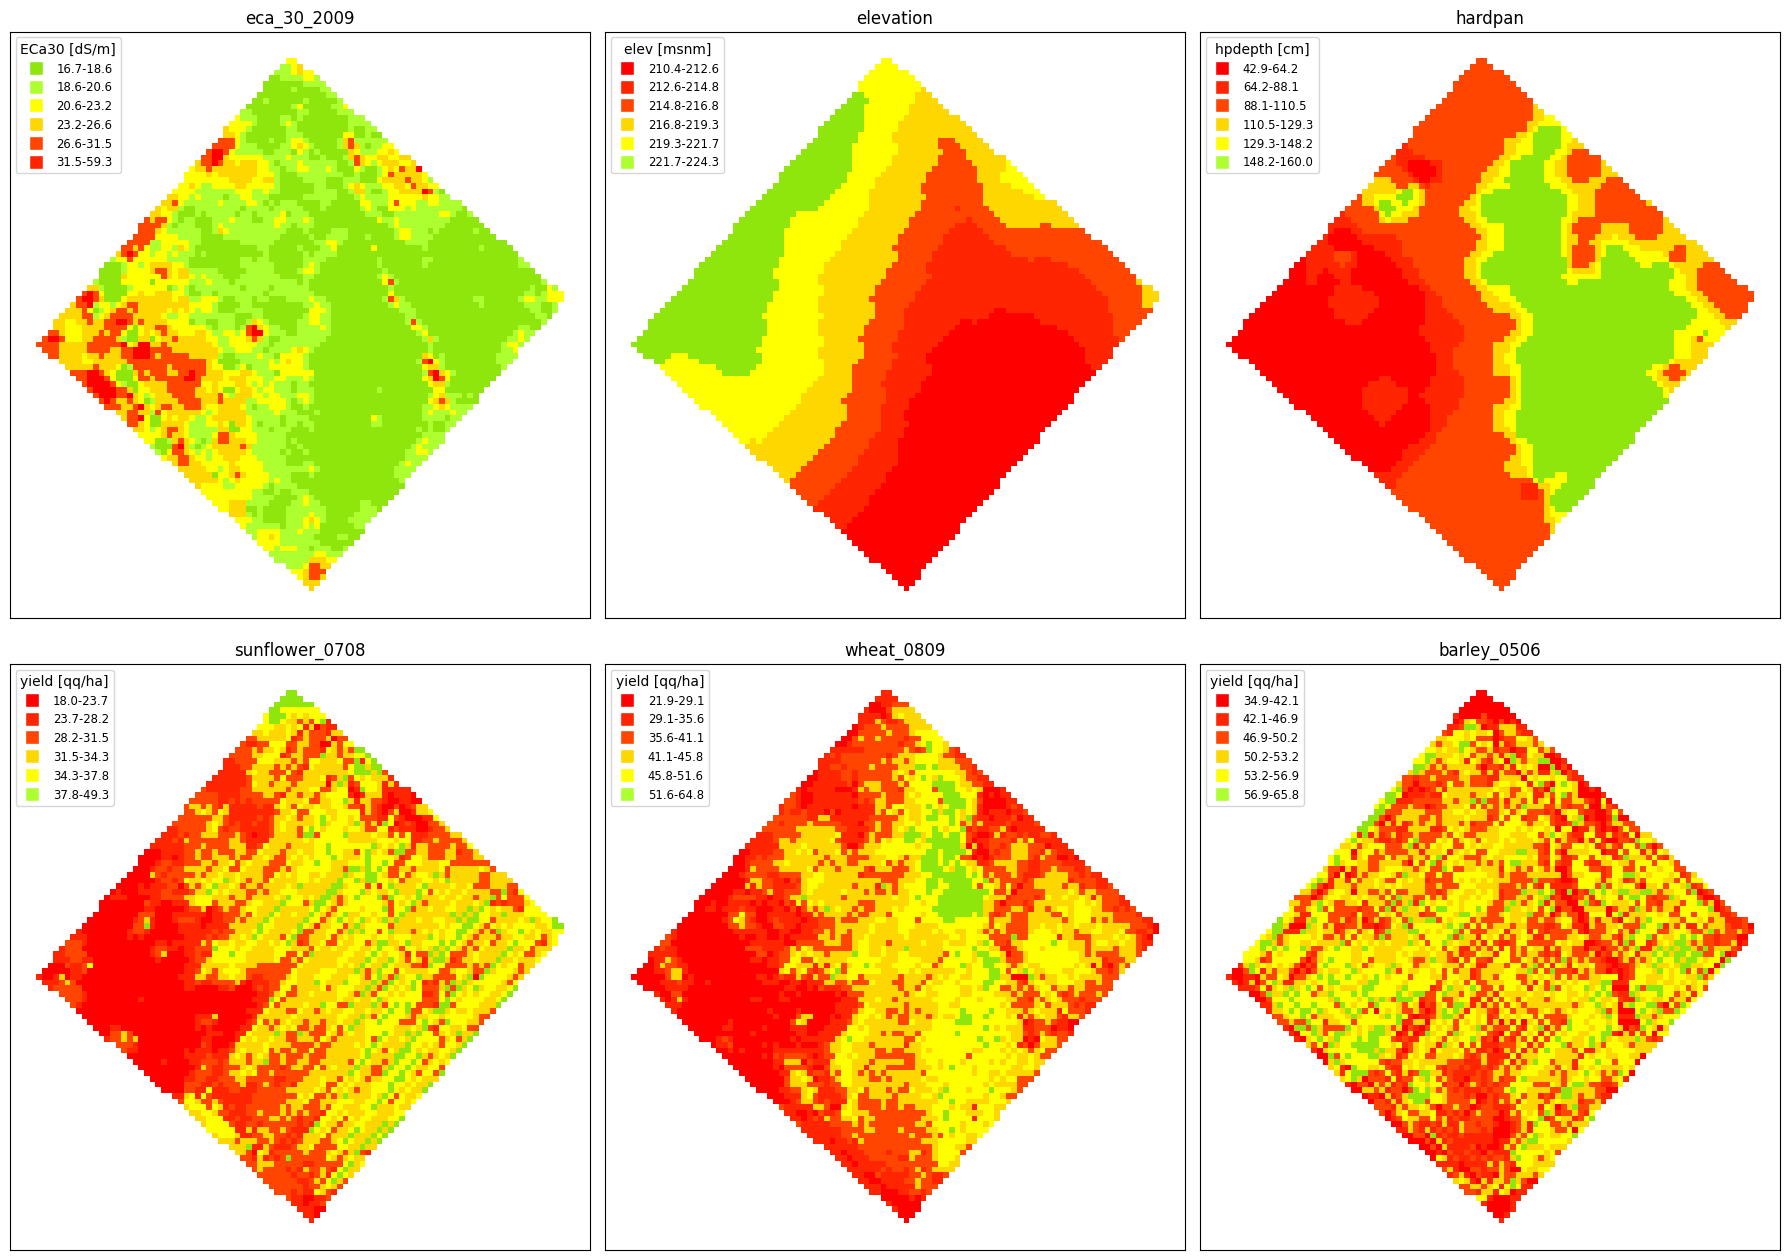

In [4]:
fig, axs = plt.subplots(2, 3, figsize=(15+3, 10+5))  # (filas, columnas)
plt.subplots_adjust(wspace=1)
layers = ['eca_30_2009','elevation','hardpan','sunflower_0708','wheat_0809','barley_0506']
colors_l = ['#8FE60C','#ADFF2F','#FFFF00','#FFD700','#FF4500','#FF2500','#FF0000']
vname = ['EC30','elevation','hpdepth','yield','yield','yield']
l_titles = ['ECa30 [dS/m]','elev [msnm]','hpdepth [cm]','yield [qq/ha]','yield [qq/ha]','yield [qq/ha]']
for i, layer in enumerate(layers):
    if i==0:
        colors=colors_l
    else:
        colors = list(reversed(colors_l))
    data = gpd.read_file(filename="Data/Field_05/field_05_pred_poly.gpkg", layer=layer)
    # Calculate breaks using pretty breaks
    classifier = mc.FisherJenks(data[vname[i]], k=7)
    #classifier = mc.Quantiles(data[vname[i]], k=7)
    breaks = classifier.bins.tolist()
    breaks = [round(b, 1) for b in breaks]
    # Create the custom color scale
    cmap = mcolors.ListedColormap(colors)
    # Define color boundaries
    norm = mcolors.BoundaryNorm(breaks, cmap.N)
    ax = axs[i // 3, i % 3]
    data.plot(ax=ax, column=vname[i], cmap=cmap, norm=norm,legend=False)
    # Add plot title
    ax.set_title(layer)
    # Removing the x y axis from plot
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    # Create a custom legend
    legend_elements = []
    for j in range(1,len(breaks)):
        legend_elements.append(Line2D([0], [0], marker='s', color='w', label=f'{breaks[j-1]}-{breaks[j]}', markerfacecolor=colors[j-1], markersize=10))
    # Add the legend to plot
    ax.legend(handles=legend_elements, title=l_titles[i], fontsize='small',loc='upper left')
plt.tight_layout()
plt.show()

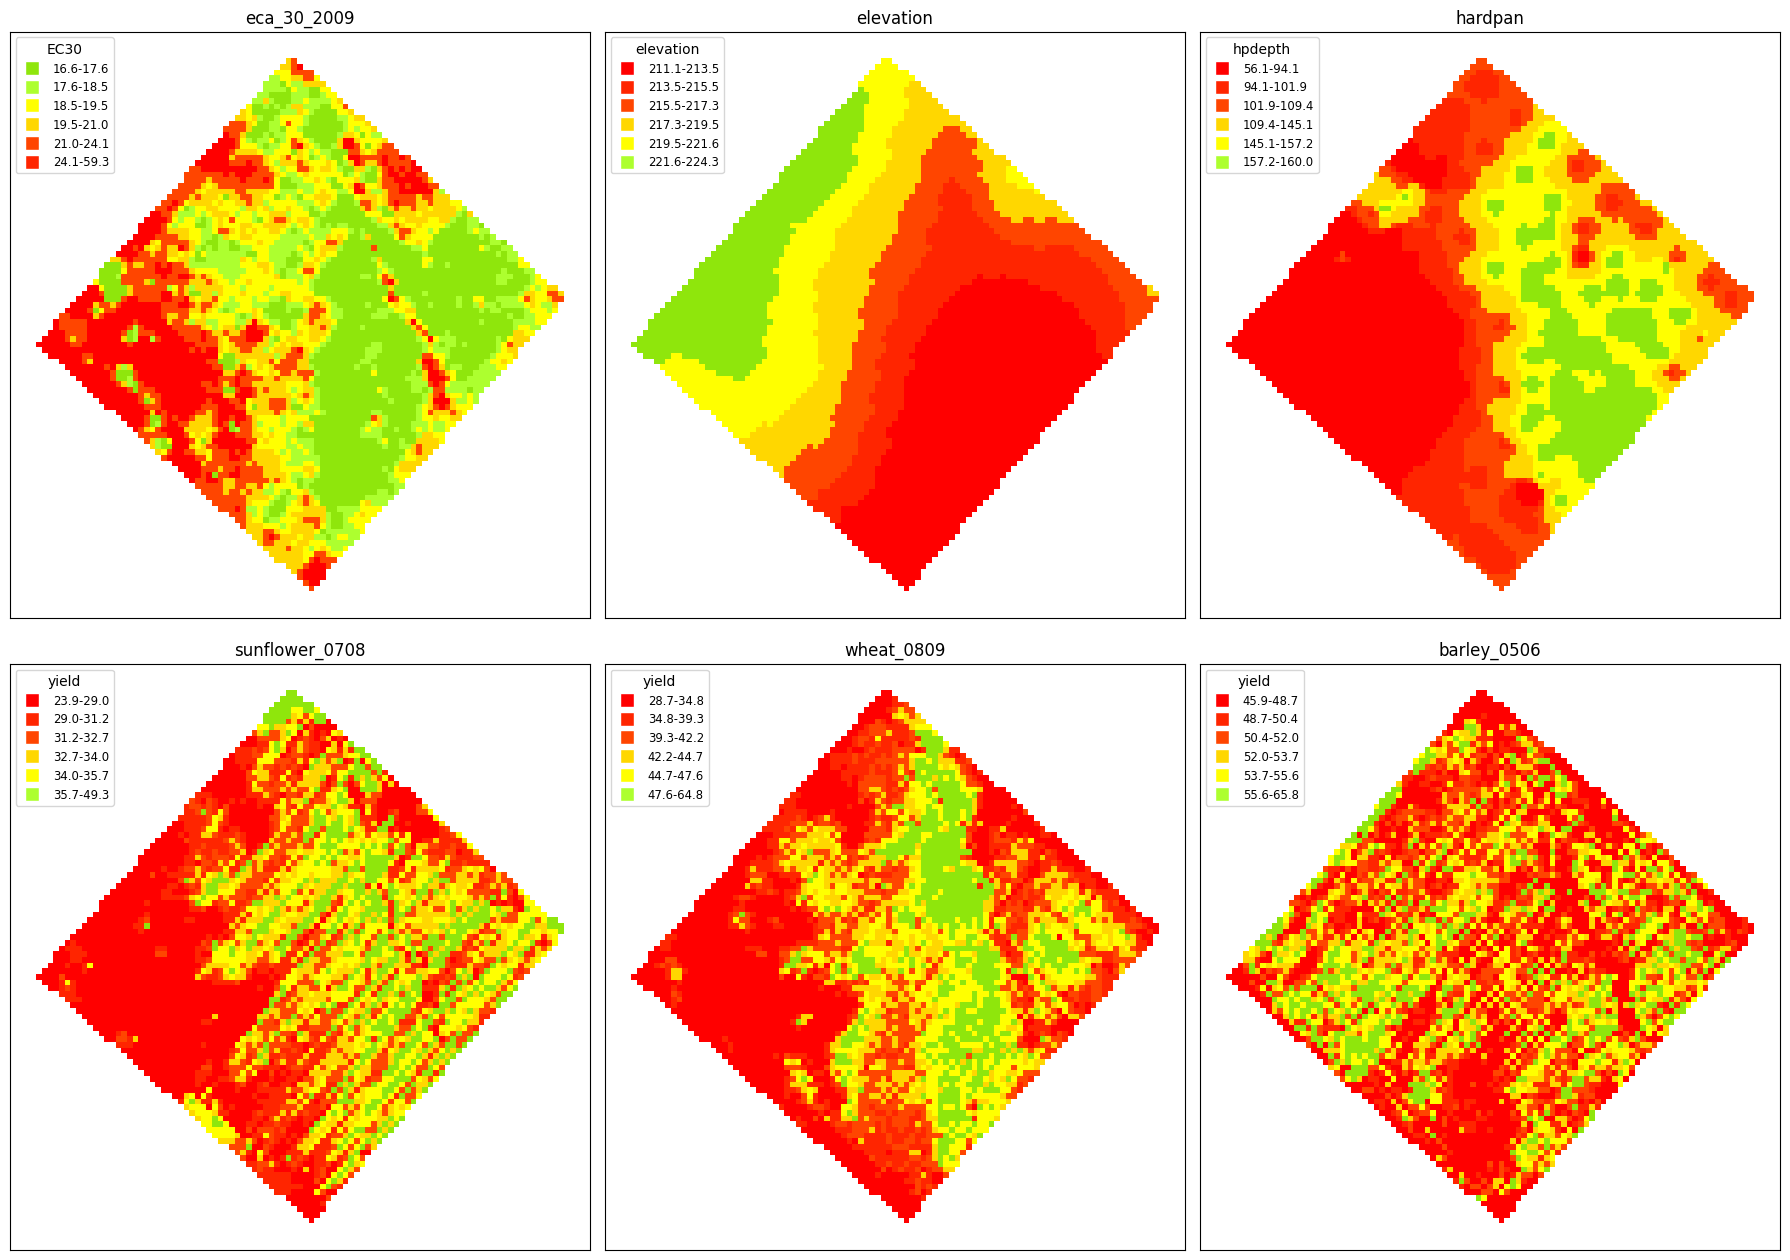

In [5]:
fig, axs = plt.subplots(2, 3, figsize=(15+3, 10+5))  # (filas, columnas)
plt.subplots_adjust(wspace=1)
layers = ['eca_30_2009','elevation','hardpan','sunflower_0708','wheat_0809','barley_0506']
colors_l = ['#8FE60C','#ADFF2F','#FFFF00','#FFD700','#FF4500','#FF2500','#FF0000']
vname = ['EC30','elevation','hpdepth','yield','yield','yield']
for i, layer in enumerate(layers):
    if i==0:
        colors=colors_l
    else:
        colors = list(reversed(colors_l))
    data = gpd.read_file(filename="Data/Field_05/field_05_pred_poly.gpkg", layer=layer)
    # Calculate breaks using pretty breaks
    #classifier = mc.FisherJenks(data[vname[i]], k=7)
    classifier = mc.Quantiles(data[vname[i]], k=7)
    breaks = classifier.bins.tolist()
    breaks = [round(b, 1) for b in breaks]
    # Create the custom color scale
    cmap = mcolors.ListedColormap(colors)
    # Define color boundaries
    norm = mcolors.BoundaryNorm(breaks, cmap.N)
    ax = axs[i // 3, i % 3]
    data.plot(ax=ax, column=vname[i], cmap=cmap, norm=norm,legend=False)
    # Add plot title
    ax.set_title(layer)
    # Removing the x y axis from plot
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    # Create a custom legend
    legend_elements = []
    for j in range(1,len(breaks)):
        legend_elements.append(Line2D([0], [0], marker='s', color='w', label=f'{breaks[j-1]}-{breaks[j]}', markerfacecolor=colors[j-1], markersize=10))
    # Add the legend to plot
    ax.legend(handles=legend_elements, title=vname[i], fontsize='small',loc='upper left')
plt.tight_layout()  # Ajustar el espaciado
plt.show()